In [4]:
suppressMessages({
    library(extRemes)
})

###################################################################################################################
# Support functions

prep_window <- function(rc = c(1,1), w = 4, h = 4) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20) }
load_ts <- function(fnm, col.names) { read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = col.names) }

Options to include:
  - shift & fixed dispersion
  - normal & GEV
  - logged or negative values

Methods needed:
  - [x] model fitting
  - [x] parameters of nonstationary model
  - [x] map to & from u
  - [x] return periods & probability ratio
  - [x] return level & change in intensity
  - [x] return level plot
  - [x] GMST trend plot
  - [x] time trend plot
  - [x] obs results for spreadsheet
  - [x] model results for spreadsheet  
  &nbsp;
  - [ ] copula fitting
  - [ ] multiple covariates
  - [ ] function to easily update model

---
## **Model fitting**

### **Nonstationary log-likelihood**

In [320]:
# nonstationary log-likelihood function
ns_loglik <- function(pars, cov1, x, dist, fittype) {

    # compute nonstationary location & scale
    if(fittype == "fixeddisp") {
        const = exp((pars["alpha"] * cov1) / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
    } else if(fittype == "shift") {
        loc = pars["mu0"] + pars["alpha"] * cov1
        scale = pars["sigma0"]
    } else {
        print(paste(fittype, "not implemented"))
        return()
    }
    
    # constrain variance to be strictly positive
    if(any(scale <= 0)) return(NA)
        
    # return negative log-likelihood
    if(dist == "norm") {
        return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
    } else if(dist == "gev") {
        shape = pars["shape"]
        return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
    } else {
        print(paste(dist, "not implemented"))
        return()
    }
}

In [6]:
# load model data for testing
log10_pr <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
            read.csv("data/test_precip.dat", comment.char = "#", sep = " ", col.names = c("year", "pr")))
log10_pr$log10_pr <- log10(log10_pr$pr)

tmax <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
            read.csv("data/test_tasmax.dat", comment.char = "#", sep = " ", col.names = c("year", "tmax")))

In [7]:
test_nsll <- function(varnm, dist, fittype, dp = 3) {
    # quick testing function
    
    df <- get(varnm)
    init <- c("mu0" = mean(df[,varnm]), "sigma0" = sd(df[,varnm]), "alpha" = 0)
    if(dist == "gev") init <- c(init, "shape" = 0)
    
    fitted <- round(optim(par = init, ns_loglik, cov1 = df$gmst, x = df[,varnm], dist = dist, fittype = fittype)$par, dp)
    if(dist == "norm") fitted <- c(fitted, "shape" = NA)[c("mu0", "sigma0", "shape", "alpha")]
    
    c("variable" = varnm, "dist" = dist, "fittype" = fittype, fitted)
}

In [8]:
rbind(test_nsll("tmax", "gev", "shift"),
      test_nsll("tmax", "gev", "fixeddisp"),
      test_nsll("log10_pr", "norm", "shift"),
      test_nsll("log10_pr", "norm", "fixeddisp"))

variable,dist,fittype,mu0,sigma0,alpha,shape
tmax,gev,shift,32.059,0.962,3.185,-0.095
tmax,gev,fixeddisp,32.11,0.929,3.017,-0.118
log10_pr,norm,shift,2.145,0.176,NA,0.127
log10_pr,norm,fixeddisp,2.145,0.171,NA,0.126


In [9]:
# results from climate explorer - not identical, but very similar
read.csv("cx-results.txt", sep = " ")

variable,dist,fittype,mu0,sigma0,shape,alpha
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
tmax,gev,shift,32.119,0.962,-0.108,3.100
tmax,gev,fixeddisp,32.135,0.914,-0.089,3.102
log10_pr,norm,shift,2.135,0.175,NA,0.141
log10_pr,norm,fixeddisp,2.134,0.169,0.146,NA
tmin,gev,shift,-0.185,-1.473,-0.107,2.383


### **Wrapper method to fit distribution**

In [119]:
# wrapper to fit nonstationary fixed-dispersion model

fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm_1, lower = F, mintemps = F, event_index = NA, ...) {
    
    # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
    if(! dist %in% c("norm", "gev")) {
        print("Not yet implemented: use norm or gev")
        return()
    }
    
    # if looking at minimum temperatures (or minima of negative values generally), need to flip data for stable model fitting
    x <- data[,varnm]; if(mintemps) x <- -x
    cov1 <- data[,covnm_1]
    
    # fit model with appropriate number of parameters, pad if necessary
    init <- c("mu0" = mean(x), "sigma0" = sd(x), "alpha" = 0)
    if(dist == "gev") init <- c(init, "shape" = 0)
    fitted <- suppressWarnings(optim(par = init, ns_loglik, cov1 = cov1, x = x, dist = dist, fittype = type))
    
    # if looking at minimum temperatures (or minima of negative values generally), so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
    if(mintemps) {
        fitted[["NOTE"]] <- "NB: model parameters are estimated for negative values"
        fitted$par["mu0"] <- -fitted$par["mu0"]
        fitted$par["alpha"] <- -fitted$par["alpha"]
        x <- -x
    }
            
    # attach assorted useful information
    fitted[["dist"]] <- dist
    fitted[["type"]] <- type
    fitted[["varnm"]] <- varnm
    fitted[["covnm_1"]] <- covnm_1
    fitted[["data"]] <- data
    fitted[["x"]] <- x
    fitted[["cov1"]] <- data[,covnm_1]
    
    fitted[["lower"]] <- lower               # saves having to specify every time later on
    fitted[["mintemps"]] <- mintemps         # look at maxima of 0-temps, rather than minima of observed temps
    
    if(is.na(event_index)) { event_index <- length(x) } # assume that year of interest is most recent, unless told otherwise (used in later plotting functions)
    fitted[["ev_idx"]] <- event_index

    return(fitted)
}

In [120]:
# load model data for testing
pr <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
            read.csv("data/test_precip.dat", comment.char = "#", sep = " ", col.names = c("year", "pr")))
pr$log10_pr <- log10(pr$pr)

tmax <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
            read.csv("data/test_tasmax.dat", comment.char = "#", sep = " ", col.names = c("year", "tmax")))

tmin <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
              read.csv("data/test_tasmin.dat", comment.char = "#", sep = " ", col.names = c("year", "tmin")))

pr_shift <- fit_ns("norm", "shift", pr, "log10_pr", "gmst", lower = T)
pr_fd <- fit_ns("norm", "fixeddisp", pr, "log10_pr", "gmst", lower = T)

tmax_shift <- fit_ns("gev", "shift", tmax, "tmax", "gmst")
tmax_fd <- fit_ns("gev", "fixeddisp", tmax, "tmax", "gmst")

tmin_shift <- fit_ns("gev", "shift", tmin, "tmin", "gmst", lower = T, mintemps = T, event_index = which(tmin$year == 1962))

## **Model parameters & estimates**

### **Get nonstationary parameters**

In [121]:
ns_pars <- function(mdl, fixed_cov = NA) {
    
    # if no covariate value given, evaluate at all covariate values
    if(is.na(fixed_cov[1])) fixed_cov <- mdl$cov1
    
    # calculate the nonstationary parameter values
    pars <- mdl$par
    if(mdl$type == "fixeddisp") {
        
        ns_const = exp((pars["alpha"] * fixed_cov) / pars["mu0"])
        loc = pars["mu0"] * ns_const
        scale = pars["sigma0"] * ns_const
        
    } else if(mdl$type == "shift") {
        loc = pars["mu0"] + pars["alpha"] * fixed_cov
        scale = rep(pars["sigma0"], length(fixed_cov))

        
    } else {
        print(paste(mdl$type,"not implemented"))
        return()
    }
        
    # return the list of named parameters: location, scale, shape (if applicable)
    if("shape" %in% names(pars)) {
        return(lapply(list("loc" = loc, "scale" = scale, "shape" = rep(pars["shape"], length(fixed_cov))), unname))
    } else {
        return(lapply(list("loc" = loc, "scale" = scale), unname))
    }
    
}

In [122]:
ns_pars(tmin_shift, tmin$gmst[tmin$year == 2022])

$loc
[1] 1.99665

$scale
[1] 1.491419

$shape
[1] -0.1208743

---
### **Exceedance probability; return period; probability ratio**

In [123]:
# convert from nonstationary distribution to stationary uniform (PIT)
map_to_u <- function(mdl, x, fixed_cov = NA) {
    
    pars <- ns_pars(mdl, fixed_cov = fixed_cov)
    if(missing(x)) x <- mdl$x
    
    # retrieve the actual fitted model parameters if they were flipped for fitting
    if(mdl$mintemps) {
        pars$loc <- -pars$loc
        x = -x
        mdl$lower <- !mdl$lower # also have to look at the opposite tail
    }
    
    # get exceedance probability
    if(mdl$dist == "norm") {
        pit <- pnorm(x, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    } else if(mdl$dist == "gev") {
        pit <- sapply(1:length(pars$loc), function(i) pevd(x[i], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower))
    } else {
        return(NULL)
    }
    return(pit)
}

In [124]:
return_period <- function(mdl, x, fixed_cov = NA) {
    
    1 / map_to_u(mdl, x, fixed_cov)
}

In [125]:
# wrapper for probability ratio
prob_ratio <- function(mdl, ev, cov, cov_cf) {
    
    if(missing(ev)) ev <- mdl$x[mdl$ev_idx]
    
    ep_f <- map_to_u(mdl, ev, fixed_cov = cov)
    ep_cf <- map_to_u(mdl, ev, fixed_cov = cov_cf)
    
    ep_f / ep_cf
}

In [126]:
# check for return periods & probability ratios at fixed covariate values
gmst_2022 <- tmin$gmst[tmin$year == 2022]
gmst_pi <- gmst_2022 - 1.2
gmst_1962 <- tmin$gmst[tmin$year == 1962]

return_period(tmin_shift, tmin$tmin[tmin$year == 1962], fixed_cov = gmst_1962)   # 332; cx has 279
return_period(tmax_shift, tmax$tmax[tmax$year == 2022], fixed_cov = gmst_2022)   # 8.2; cx has 8.4
return_period(pr_fd, pr$log10_pr[pr$year == 2022], fixed_cov = gmst_2022)        # 4.7; cx has 4.6

[1] 332.1141

[1] 8.230717

[1] 4.68009

In [127]:
prob_ratio(tmin_shift, cov = gmst_1962, cov_cf = gmst_2022)   # 33.98; cx has 21.4
prob_ratio(tmax_shift, cov = gmst_2022, cov_cf = gmst_pi)     # 601.9; cx has 261
prob_ratio(pr_fd, cov = gmst_2022, cov_cf = gmst_pi)          # 0.405; cx has 0.39

[1] 33.97735

[1] 601.8673

[1] 0.4051697

### **Effective return level, change in intensity**

In [174]:
# convert from exceedance probability to value conditioned on stationary distribution with specified covariates
map_from_u <- function(u, mdl, fixed_cov = NA) {
    
    pars <- ns_pars(mdl, fixed_cov = fixed_cov)
    
    # retrieve the actual fitted model parameters if they were flipped for fitting
    if(mdl$mintemps) {
        pars$loc <- -pars$loc
        mdl$lower <- !mdl$lower       # also have to look at the opposite tail
    }
        
    # map quantile onto stationary distribution
    if(mdl$dist == "norm") {
        erl <- sapply(1:length(u), function(j) {
            qnorm(u[j], mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
        })
    } else if(mdl$dist == "gev") {
        erl <- sapply(1:length(u), function(j) {
            sapply(1:length(pars$loc), function(i) {
                qevd(u[j], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower)
            })
        })
    } else {
        return(NULL)
    }
                      
    # if parameters flipped for fitting, flip 'em back
    if(mdl$mintemps) erl <- -erl
                      
    return(erl)
}

In [150]:
eff_return_level <- function(rp, mdl, fixed_cov = NA) {
    
    map_from_u(1/rp, mdl, fixed_cov = fixed_cov)
}

In [149]:
eff_return_level(tmin_shift, rp = 300, fixed_cov = gmst_1962)

[1] -6.271976

In [131]:
int_change <- function(mdl, rp = NA, cov, cov_cf, relative = F) {
    
    if(is.na(rp)) {
        if(relative) {
            cat("Return period needed to calculate relative change")
            return(NA)
        } else {
            rp <- 10
        }
    }
    # if return period is less than 1, assume it's an exceedance probability and convert to a return period
    if(rp < 1) { rp <- 1/rp } else { rp <- rp }
    
    # get effective return levels
    rl <- eff_return_level(rp, mdl, fixed_cov = cov)
    rl_cf <- eff_return_level(rp, mdl, fixed_cov = cov_cf)
    
    # if variable is logged, convert to real values first
    if(substr(mdl$varnm, 1, 5) == "log10") {
        rl <- 10^rl
        rl_cf <- 10^rl_cf
    } else if (substr(mdl$varnm, 1, 3) == "log"){
        rl <- exp(rl)
        rl_cf <- exp(rl_cf)
    }
    
    if(relative) {
        (rl - rl_cf) / rl_cf * 100
    } else {
        rl - rl_cf
    }
}

In [132]:
int_change(tmin_shift, cov = gmst_1962, cov_cf = gmst_2022, relative = F)   # -2.12; cx has -2.114
int_change(tmax_shift, cov = gmst_2022, cov_cf = gmst_pi, relative = F)     # 3.82; cx has 3.738

int_change(pr_fd, rp = return_period(pr_fd)[pr_fd$ev_idx], cov = gmst_2022, cov_cf = gmst_pi, relative = T)   # 39.6%; cx has 8.219% but this is known to be incorrect, because it's the ratio of the logprecip

[1] -2.123488

[1] 3.822242

[1] 39.57223

## **Plotting**

### **Return level plots**

In [133]:
plot_returnlevels <- function(mdl, cov, cov_cf, ylim = NA, pch = 20, ylab = NA, legend_pos = "topright", main = "", xlim = c(1,10000), legend_labels = c("Present climate", "Counterfactual climate"),
                              seed = 42, nsamp = 500, ...) {
    
    x <- mdl$x
    event_value <- x[mdl$ev_idx]
    rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
    rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # prep axes
    if(is.na(ylim[1])) { ylim <- range(pretty(x)) }
    if(is.na(ylab)) {ylab <- mdl$varnm}
    if((substr(mdl$varnm,1,3) == "log") & (ylim[1] <= 0)) { ylim[1] <- 0.01 }
    
    plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
    mtext("Return period (years)", side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA), bty = "n")

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # calculate return periods & return levels
    
    rl_curve_pres <- map_from_u(1/rp_x, mdl, fixed_cov = cov)
    rl_curve_cf <- map_from_u(1/rp_x, mdl, fixed_cov = cov_cf)
    
    rl_obs_pres <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov)
    rl_obs_cf <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov_cf)
    
    rp_event_pres <- 1/map_to_u(mdl, x[mdl$ev_idx], fixed_cov = cov)
    rp_event_cf <- 1/map_to_u(mdl, x[mdl$ev_idx], fixed_cov = cov_cf)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # return period curves
    lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
    lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual
    
    # expected return periods vs return levels transformed to stationarity at that covariate value
    points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
    points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual
    
    # horizontal line showing observed event, plus ticks showing return periods
    abline(h = event_value, col = "magenta", lty = 2)
    suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
    suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Add confidence intervals to return periods
    
    if(!is.na(nsamp)) {
        x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
        set.seed(seed)
        
        mdl_df <- setNames(data.frame(mdl$x, mdl$cov1), c(mdl$varnm, mdl$covnm_1)) 
        boot_res <- sapply(1:nsamp, function(i) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
            tryCatch({
                boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, lower = mdl$lower, mintemps = mdl$mintemps, event_index = mdl$ev_idx)
                c(map_from_u(1/x_ci, boot_mdl, fixed_cov = cov), map_from_u(1/x_ci, boot_mdl, fixed_cov = cov_cf))
            }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
        })
        boot_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
        
        # matplot(x_ci, t(boot_ci[,1:length(x_ci)]), type = "l", lty = 1, lwd = 2, col = adjustcolor("firebrick", alpha = 0.3), add = T)
        # matplot(x_ci, t(boot_ci[,-(1:length(x_ci))]), type = "l", lty = 1, lwd = 2, col = adjustcolor("blue", alpha = 0.3), add = T)
        
        # shaded region for confidence intervals
        polygon(x = c(x_ci, rev(x_ci)), y = c(boot_ci[1,1:length(x_ci)], rev(boot_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
        polygon(x = c(x_ci, rev(x_ci)), y = c(boot_ci[1,-(1:length(x_ci))], rev(boot_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", alpha = 0.1))
    }
}

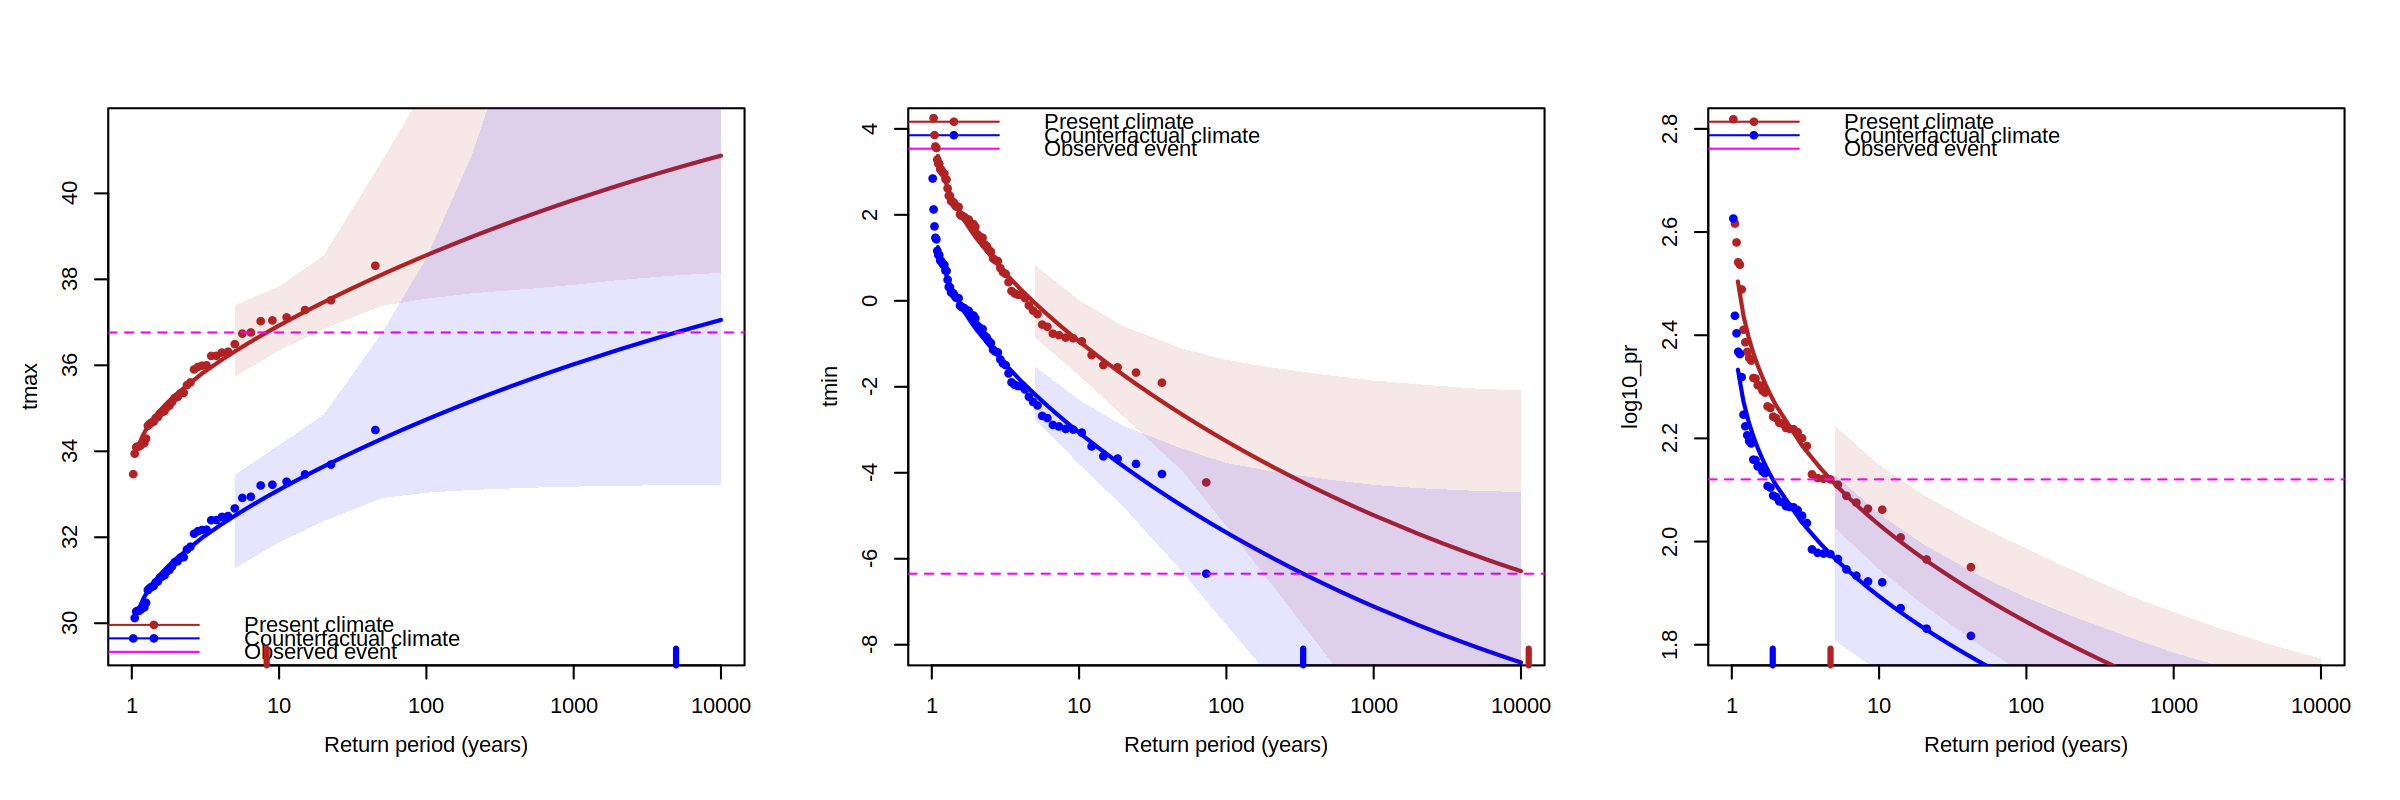

In [134]:
prep_window(c(1,3))

plot_returnlevels(tmax_shift, cov = gmst_2022, cov_cf = gmst_pi, ylim = c(29.5, 41.5), legend_pos = "bottomright")
plot_returnlevels(tmin_shift, cov = gmst_2022, cov_cf = gmst_1962)
plot_returnlevels(pr_fd, cov = gmst_2022, cov_cf = gmst_pi)

### **GMST trend plots**

In [210]:
plot_gmsttrend <- function(mdl, cov, cov_cf, ylim = NA, ylab = NA, legend_pos = "topleft", main = "", seed = 42, nsamp = 1000) {

    if(is.na(ylab)) { ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    
    plot(mdl$cov1, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = range(c(mdl$cov1, cov, cov_cf)))
    mtext("GMST anomaly", side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    points(mdl$cov1[mdl$ev_idx], mdl$x[mdl$ev_idx], col = "magenta", lwd = 2, pch = 0)
    
    # trend lines
    lines(mdl$cov1, ns_pars(mdl)$loc, lwd = 3, col = "black", lty = 1)
    lines(mdl$cov1, eff_return_level(6, mdl), col = "blue", lwd = 2, lty = 1)
    lines(mdl$cov1, eff_return_level(40, mdl), col = "blue", lwd = 1, lty = 1)
    
    # get confidence interval for mu'
    mdl_df <- mdl$data
    set.seed(seed)
    mu_ci <- apply(sapply(1:nsamp, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        tryCatch({
            boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, lower = mdl$lower, mintemps = mdl$mintemps, event_index = mdl$ev_idx)
            c("mu_ev" = ns_pars(boot_mdl, fixed_cov = cov)$loc,
              "mu_cf" = ns_pars(boot_mdl, fixed_cov = cov_cf)$loc)
        }, error = function(cond) {return(rep(NA, 2))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)
    
    # confidence interval & markers for mu' at factual & counterfactual covariates
    lines(rep(cov, 3), c(ns_pars(mdl, fixed_cov = cov)$loc, mu_ci[,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
    lines(rep(cov_cf, 3), c(ns_pars(mdl, fixed_cov = cov_cf)$loc, mu_ci[,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

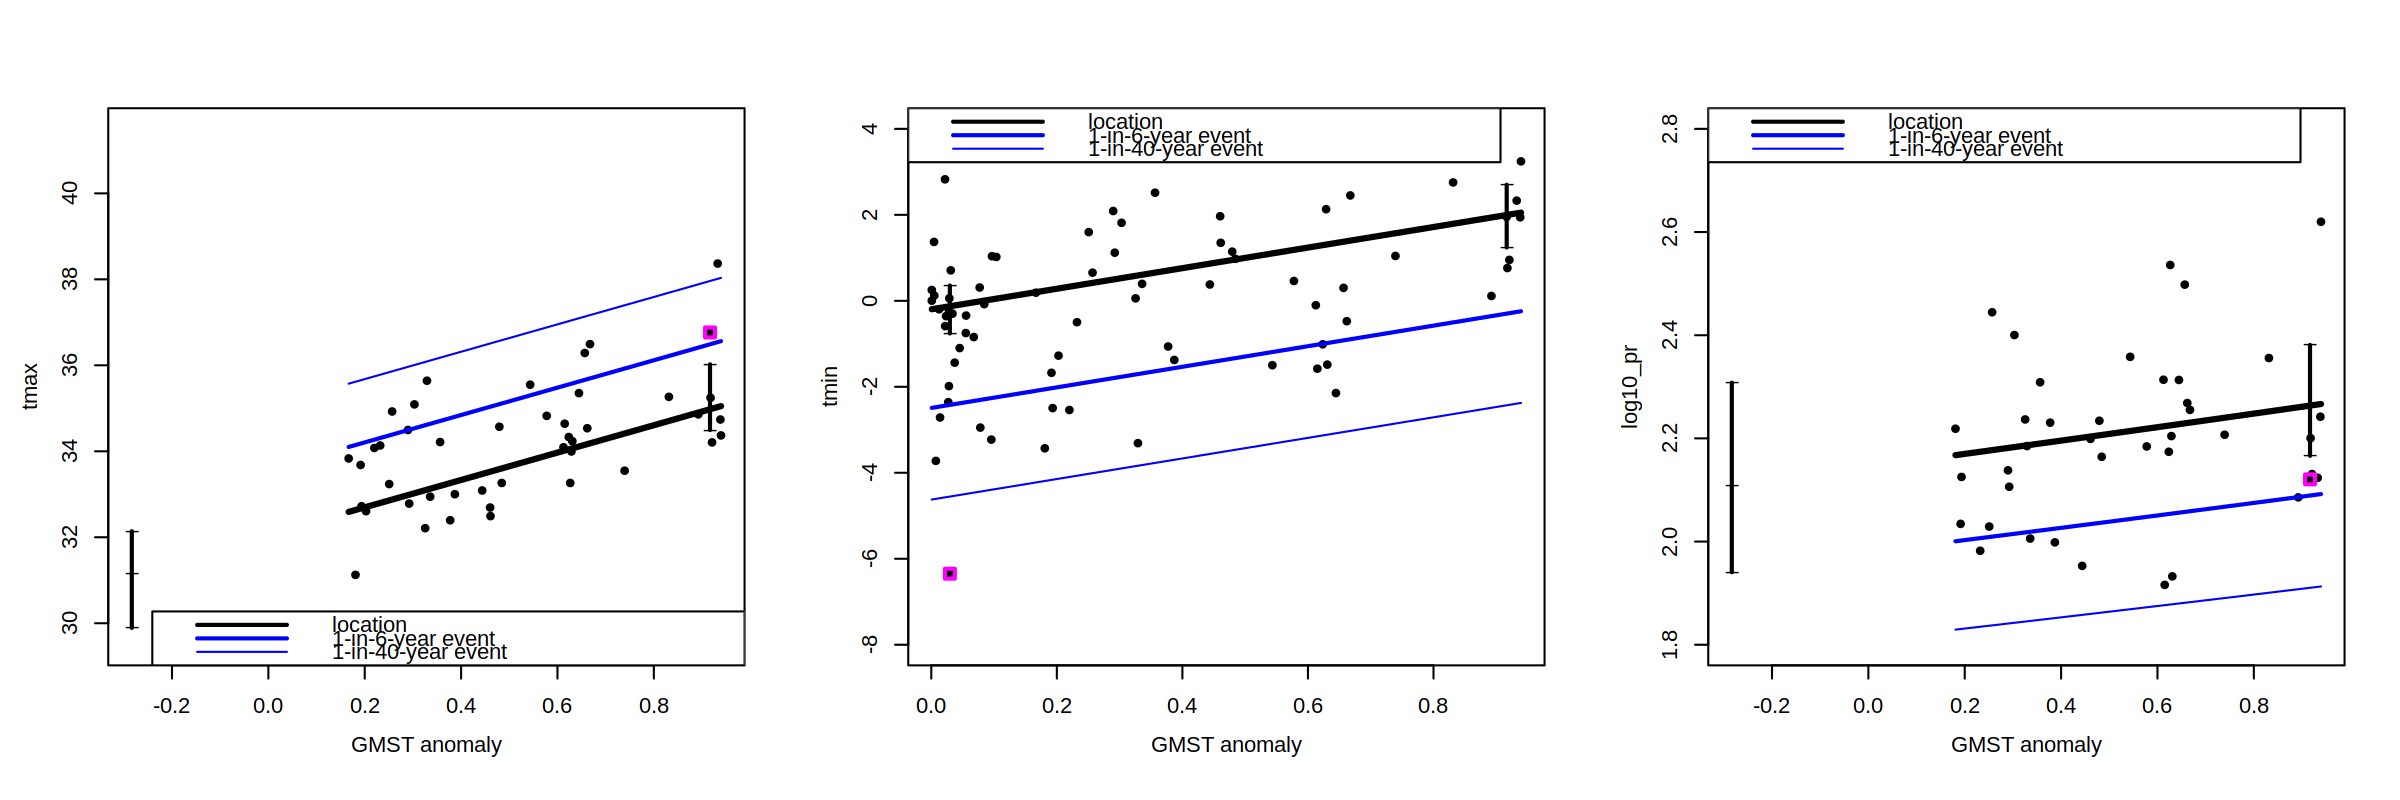

In [136]:
prep_window(c(1,3))

plot_gmsttrend(tmax_shift, cov = gmst_2022, cov_cf = gmst_pi, ylim = c(29.5, 41.5), legend_pos = "bottomright")
plot_gmsttrend(tmin_shift, cov = gmst_2022, cov_cf = gmst_1962)
plot_gmsttrend(pr_fd, cov = gmst_2022, cov_cf = gmst_pi)

### **Trend plots**

In [176]:
plot_trend <- function(mdl, ylab = NA, legend_pos = "topleft", main = "", ...) {
    
    if(is.na(ylab)) {ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    
    plot(mdl$data$year, mdl$x, type = "s", lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylab = ylab, main = main, ...)
    
    lines(mdl$data$year, ns_pars(mdl)$loc, col = "black", lwd = 2)
    matplot(mdl$data$year, eff_return_level(c(6,40), mdl), type = "l", lty = 1, add = T, col = "blue", lwd = c(2,1))
    
    points(mdl$data$year[mdl$ev_idx], mdl$x[mdl$ev_idx], col = "magenta", lwd = 2, pch = 0)
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

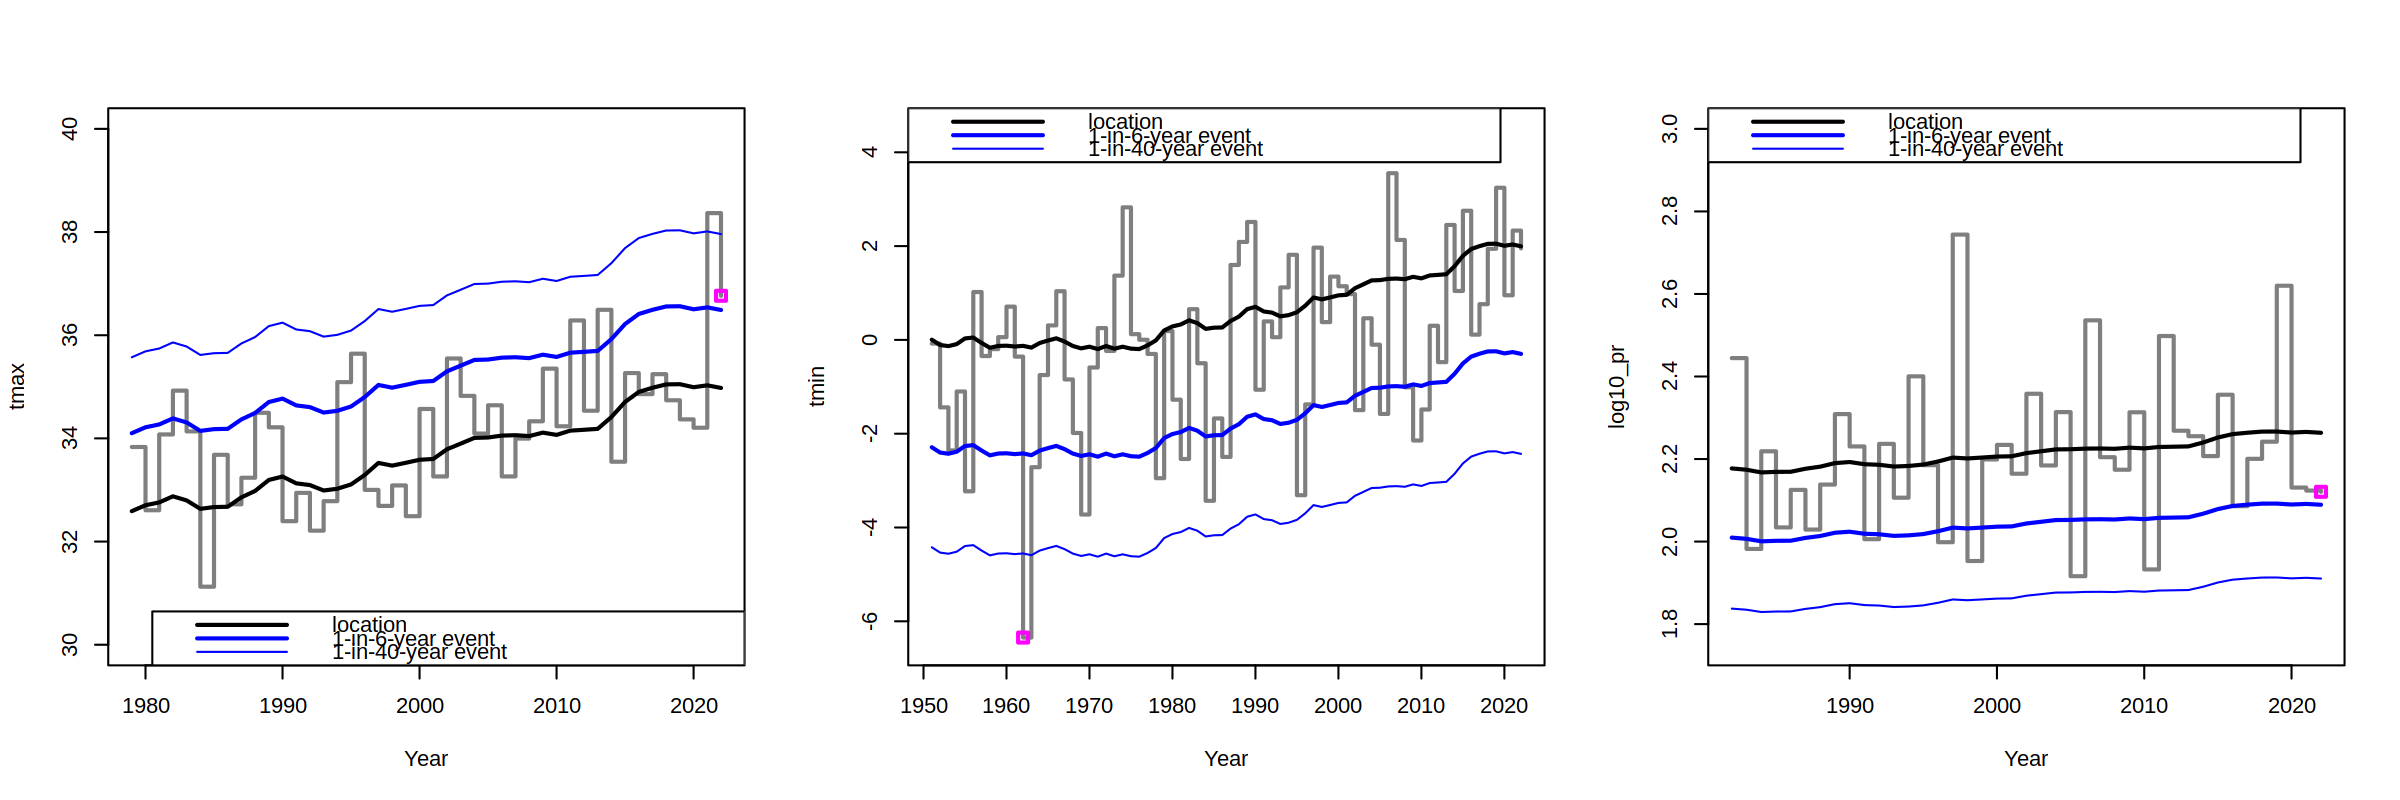

In [183]:
prep_window(c(1,3))

plot_trend(tmax_shift, legend_pos = "bottomright", ylim = c(30,40))
plot_trend(tmin_shift, ylim = c(-6.5,4.5))
plot_trend(pr_fd, ylim = c(1.75, 3))

---
## **Results for spreadsheet**

In [213]:
# support function to extract results from fitted model
mdl_ests <- function(mdl, cov, cov_cf, ev, rp = NA) {

    pars <- mdl$par
    disp <- unname(pars["sigma0"] / pars["mu0"])

    if(is.na(rp)) rp <- return_period(mdl, ev, fixed_cov = cov)

    if(is.finite(rp)) {
        c(pars,
          "disp" = disp, 
          "event_magnitude" = ev, 
          "return_period" = rp, 
          "PR" = prob_ratio(mdl, ev, cov, cov_cf),
          "dI_abs" = int_change(mdl, rp, cov, cov_cf, relative = F),
          "dI_rel" = int_change(mdl, rp, cov, cov_cf, relative = T))
    } else {
        return(rep(NA, 10))
    }
}

In [214]:
# wrapper function to get bootstrapped confidence intervals for spreadsheet
boot_ci <- function(mdl, cov, cov_cf, ev = NA, rp = NA, seed = 42, nsamp = 500, dp = 5) {
    
    # get best estimate from the observed data
    if(is.na(ev)) ev  <- mdl$x[mdl$ev_idx]
    mdl_res <- mdl_ests(mdl, cov, cov_cf, ev, rp = rp)
    
    # get bootstrap sample
    set.seed(seed)    
    boot_res <- sapply(1:nsamp, function(i) {
        boot_df <- mdl$data[sample(1:nrow(mdl$data), replace = T),]
        tryCatch({
            boot_mdl <- fit_ns(mdl$dist, mdl$type, boot_df, varnm = mdl$varnm, covnm_1 = mdl$covnm_1, lower = mdl$lower, mintemps = mdl$mintemps, event_index = mdl$ev_idx)
            mdl_ests(boot_mdl, cov, cov_cf, ev, rp = rp)
        },
        error = function(cond) {return(rep(NA, 10))})
    })
    boot_qq <- t(rbind("bestimate" = mdl_res, apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)))
    if(!is.na(dp)) boot_qq <- round(boot_qq, dp)
    return(boot_qq)
}

In [268]:
# FUNCTION TO CARRY OUT ALL ATTRIBUTION RUNS & PRODUCE RESULTS IN SPREADSHEET-FRIENDLY FORM
cmodel_results <- function(mdl, rp = 10, cov_pres, cov_pi = NA, cov_fut = NA, nsamp = 5, seed = 42, di_relative = NA) {
    
    set.seed(seed)
    
    # fill in missing parameters
    if(is.na(cov_pi)) cov_pi <- cov_pres - 1.2
    if(is.na(cov_fut)) cov_fut <- cov_pres + 0.8
    if(is.na(di_relative)) di_relative <- mdl$type == "fixeddisp"
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # FIT MODEL to three different subsets: for evaluation, attribution & projection
    
    df <- mdl$data
    
    # fit models
    mdl_eval <- fit_ns(mdl$dist, mdl$type, df[df$year >= 1979 & df$year <= 2023,], varnm = mdl$varnm, covnm_1 = mdl$covnm_1, lower = mdl$lower, mintemps = mdl$mintemps, event_index = mdl$ev_idx)
    mdl_attr <- fit_ns(mdl$dist, mdl$type, df[df$year <= 2023,], varnm = mdl$varnm, covnm_1 = mdl$covnm_1, lower = mdl$lower, mintemps = mdl$mintemps, event_index = mdl$ev_idx)
    mdl_proj <- fit_ns(mdl$dist, mdl$type, df[df$year <= 2050,], varnm = mdl$varnm, covnm_1 = mdl$covnm_1, lower = mdl$lower, mintemps = mdl$mintemps, event_index = mdl$ev_idx)
    
    # get return level to use for analysis
    event_rl <- eff_return_level(rp = rp, mdl_attr, fixed_cov = cov_pres)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## Bootstrap each set of model results
    
    if(di_relative) { di_cnm <- "dI_rel" } else { di_cnm <- "dI_abs" }
    if(mdl$type == "fixeddisp") { key_par <- "disp" } else { key_par <- "sigma0" }

    ci_eval <- boot_ci(mdl_eval, cov = cov_pres, cov_cf = cov_pi, ev = event_rl, rp = rp, nsamp = nsamp)[c(key_par, "shape"),]
    ci_attr <- boot_ci(mdl_attr, cov = cov_pres, cov_cf = cov_pi, ev = event_rl, rp = rp, nsamp = nsamp)[c("PR", di_cnm),]
    ci_proj <- boot_ci(mdl_proj, cov = cov_pres, cov_cf = cov_fut, ev = event_rl, rp = rp, nsamp = nsamp)[c("PR", di_cnm),]
                   
    # invert future projections
    ci_proj["PR",] <- 1/ci_proj["PR",c(1,3,2)]
    ci_proj[di_cnm,] <- -ci_proj[di_cnm, c(1,3,2)]
    
    # flatten & rename
    ci_eval <- unlist(lapply(rownames(ci_eval), function(cnm) setNames(ci_eval[cnm,], paste("eval", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    ci_attr <- unlist(lapply(rownames(ci_attr), function(cnm) setNames(ci_attr[cnm,], paste("attr", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    ci_proj <- unlist(lapply(rownames(ci_proj), function(cnm) setNames(ci_proj[cnm,], paste("proj", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
                         
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    res <- t(data.frame(c(ci_eval, "rp_value" = event_rl, ci_attr, ci_proj)))     
    rownames(res) <- paste0(mdl$varnm, " ~ ", mdl$covnm_1, " (rp", rp,")")
    return(res)
}

In [269]:
cmodel_results(tmax_shift, rp = 10, cov_pres = gmst_2022, nsamp = 1000)

,eval_sigma0_est,eval_sigma0_lower,eval_sigma0_upper,eval_shape_est,eval_shape_lower,eval_shape_upper,rp_value,attr_PR_est,attr_PR_lower,attr_PR_upper,attr_dI-abs_est,attr_dI-abs_lower,attr_dI-abs_upper,proj_PR_est,proj_PR_lower,proj_PR_upper,proj_dI-abs_est,proj_dI-abs_lower,proj_dI-abs_upper
tmax ~ gmst (rp10),0.96163,0.66038,1.27075,-0.09515,-0.4739,0.33291,36.92608,728.2413,5.99191,Inf,3.82224,2.50445,5.8182,8.401243,2.875877,14.74057,2.54816,1.66964,3.8788


### **Trend analysis example - CORDEX**

In [322]:
# loop over all available models, get results for each
invisible(sapply(list.files("data", pattern = "rx21day-amj_EUR-11", full.names = T), function(fnm) {
    
    # results will be saved in a .csv file, one per model
    res_fnm <- paste0("res/res_",gsub("data/", "", gsub(".dat", "", fnm)), ".csv")
    print(fnm)
    if(!file.exists(res_fnm)) {   # won't replace any files that already exist - have to delete manually first
        
        # identify the correct GMST file
        gmst_fnm <- list.files("data", paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4], "_rcp85_", strsplit(fnm, "_")[[1]][5], ".dat"), full.names = T)
        
        # load data & merge into single dataframe
        var <- read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "var"))
        gmst <- read.csv(gmst_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst"))
        df <- merge(gmst, var)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # SPECIFY MODEL TO BE ANALYSED
        
        # return period of event
        rp <- 10
        
        # value of covariate in present/factual climate
        event_cov <- df[df$year == 2023, "gmst"]
        
        # fit the model - this is used as a template for the attribution
        mdl <- fit_ns("gev", "fixeddisp", df, "var", "gmst", lower = F, mintemps = F, event_index = which(df$year == 2023))
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        # get model results & save as .csv
        res_df <- cmodel_results(mdl, rp = rp, cov_pres = event_cov, nsamp = 50)
        rownames(res_df) <- gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][4:6], collapse = "_"))
        write.csv(res_df, res_fnm)
    }
}))

[1] "data/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_HadREM3-GA7-05.dat"
[1] "data/Italy-floods_rx21day-amj_EUR-11_EC-EARTH_r12_HadREM3-GA7-05.dat"
[1] "data/Italy-floods_rx21day-amj_EUR-11_HadGEM2-ES_r1_HadREM3-GA7-05.dat"
[1] "data/Italy-floods_rx21day-amj_EUR-11_MPI-ESM-LR_r1_HadREM3-GA7-05.dat"
[1] "data/Italy-floods_rx21day-amj_EUR-11_NorESM1-M_r1_HadREM3-GA7-05.dat"


In [323]:
# compile into single file 
res <- do.call("rbind", sapply(list.files("res", pattern = "EUR-11", full.names = T), read.csv, row.names = 1, simplify = F))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][5:7], collapse = "_")))
write.csv(res, "res/cordex-results.csv")

---
## **Synthesis**

In [21]:
df <- read.csv("data/synthesis-in_int-change-absolute.txt", comment.char = "#", sep = " ", header = F,
              col.names = c("y0", "y1", "est", "lower", "upper", "ci", "models", "scenario", "size"))

In [25]:
obs <- df[df$size == "OBS",]
models <- df[df$size != "OBS",]

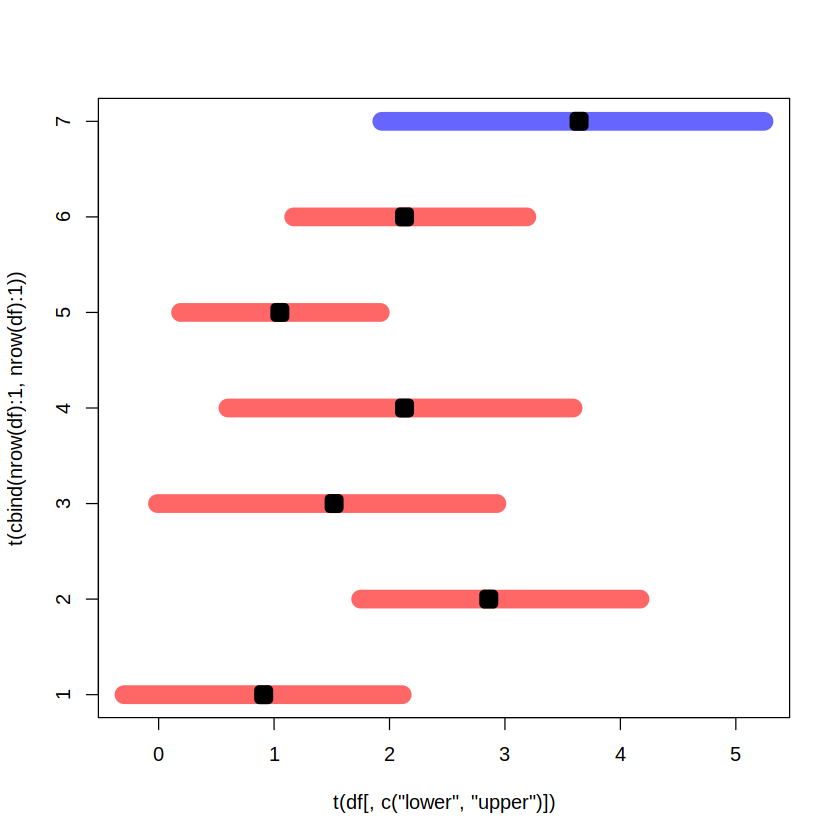

In [54]:
matplot(t(df[,c("lower", "upper")]), t(cbind(nrow(df):1, nrow(df):1)), type = "l", lty = 1, lwd = 15, col = adjustcolor(c("red", "blue")[(df$size == "OBS")+1], alpha = 0.6))
matplot(df$est, nrow(df):1, add = T, pch = 0, lwd = 8)